### How well can matchplay statistics accurately classify match winners and losers?

In [536]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import random


urls = []
for u in np.arange(19,24,1):
    urls.append(f'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_20{u}.csv')

df = pd.concat([pd.read_csv(url) for url in urls])

# encode counties as binary
countries_encoded = pd.get_dummies(df[['winner_ioc', 'loser_ioc']])

#create unique match ID
df['match_id'] = df['tourney_id'].astype(str) + '-' + df['match_num'].astype(str)

df = df[df.tourney_level != 'D'] # exclude Davis Cup
df.sort_values(by=['tourney_date', 'tourney_id', 'match_num'], inplace=True)
df.groupby(['winner_id']).cumcount().add(1)
df.reset_index(inplace=True)
df.head()

,index,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,match_id
0,57,2019-0451,Doha,Hard,32,A,20181231,270,105732,NaN,...,23.0,13.0,10.0,1.0,3.0,55.0,903.0,8.0,4095.0,2019-0451-270
1,56,2019-0451,Doha,Hard,32,A,20181231,271,109739,NaN,...,19.0,10.0,8.0,4.0,7.0,74.0,706.0,59.0,855.0,2019-0451-271
2,55,2019-0451,Doha,Hard,32,A,20181231,272,104607,NaN,...,33.0,14.0,11.0,2.0,4.0,71.0,715.0,34.0,1125.0,2019-0451-272
3,54,2019-0451,Doha,Hard,32,A,20181231,273,104269,8.0,...,21.0,14.0,9.0,7.0,11.0,28.0,1410.0,109.0,525.0,2019-0451-273
4,53,2019-0451,Doha,Hard,32,A,20181231,274,106065,4.0,...,34.0,9.0,9.0,8.0,11.0,20.0,1819.0,134.0,424.0,2019-0451-274


In [608]:
metadata = df[list(filter(re.compile('.*name').match, df.columns))]
# match_pre_data = np.array()
matchplay_stats = pd.concat([df[list(filter(re.compile('^w_|winner_rank$').match, df.columns))], df[list(filter(re.compile('^l_|loser_rank$').match, df.columns))], df['surface']], axis = 1)
matchplay_stats.dropna(inplace=True)
print(matchplay_stats.describe())
matchplay_stats.head()

              w_ace          w_df        w_svpt       w_1stIn      w_1stWon  \
count  10689.000000  10689.000000  10689.000000  10689.000000  10689.000000   
mean       7.070166      2.639162     79.685845     50.351202     38.052858   
std        5.721857      2.320487     29.464296     19.401022     13.778472   
min        0.000000      0.000000      4.000000      2.000000      1.000000   
25%        3.000000      1.000000     58.000000     36.000000     28.000000   
50%        6.000000      2.000000     74.000000     47.000000     36.000000   
75%       10.000000      4.000000     96.000000     61.000000     45.000000   
max       54.000000     26.000000    244.000000    161.000000    106.000000   

           w_2ndWon       w_SvGms     w_bpSaved     w_bpFaced   winner_rank  \
count  10689.000000  10689.000000  10689.000000  10689.000000  10689.000000   
mean      16.190663     12.806904      3.503508      5.083918     59.346805   
std        6.682333      4.268972      3.124717    

,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,winner_rank,...,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,loser_rank,surface
0,6.0,0.0,63.0,41.0,33.0,13.0,11.0,1.0,1.0,55.0,...,2.0,57.0,34.0,23.0,13.0,10.0,1.0,3.0,8.0,Hard
1,8.0,0.0,48.0,34.0,30.0,8.0,9.0,2.0,2.0,74.0,...,4.0,50.0,27.0,19.0,10.0,8.0,4.0,7.0,59.0,Hard
2,6.0,1.0,73.0,43.0,33.0,17.0,11.0,1.0,2.0,71.0,...,4.0,73.0,42.0,33.0,14.0,11.0,2.0,4.0,34.0,Hard
3,9.0,0.0,54.0,36.0,30.0,6.0,10.0,0.0,2.0,28.0,...,1.0,69.0,40.0,21.0,14.0,9.0,7.0,11.0,109.0,Hard
4,5.0,3.0,56.0,42.0,35.0,6.0,9.0,1.0,1.0,20.0,...,3.0,79.0,58.0,34.0,9.0,9.0,8.0,11.0,134.0,Hard


In [609]:
# for each predictor, calculate the difference between the player 0 and player 1 value, and append it to new df

num_preds = int((len(matchplay_stats.columns) / 2) - 1)

matchplay_stats_agg = pd.DataFrame()
for i in np.arange(num_preds):
    matchplay_stats_agg[re.sub(".*_", "diff_in_", matchplay_stats.columns[i])] = matchplay_stats.iloc[:,i] - matchplay_stats.iloc[:,i + num_preds]
    
#for a random subset of row,(winner_player = 0), player 0 (whose stats player 1's stats were subtracted from) will remain the winner
# for the remaining rows (winner_player = 1), player 1 will be converted to winner by reversing the sign for all stats columns

matchplay_stats_agg['winner_player'] = [random.randint(0,1) for r in np.arange(len(matchplay_stats_agg))]

# multiply all columns except 'winner_player' by -1 for rows where 'winner_player' is 1
cols_to_multiply = matchplay_stats_agg.columns[~(matchplay_stats_agg.columns == 'winner_player')]
matchplay_stats_agg.loc[matchplay_stats_agg['winner_player'] == 1, cols_to_multiply] *= -1
matchplay_stats_agg = pd.concat([pd.get_dummies(matchplay_stats['surface']).astype(int), matchplay_stats_agg], axis = 1)

print(matchplay_stats_agg.describe())
matchplay_stats_agg.head(10)

               Clay         Grass          Hard   diff_in_ace    diff_in_df  \
count  10689.000000  10689.000000  10689.000000  10689.000000  10689.000000   
mean       0.320984      0.103190      0.575826     -0.123398      0.049677   
std        0.466877      0.304221      0.494240     84.486741      5.956559   
min        0.000000      0.000000      0.000000  -1158.000000    -63.000000   
25%        0.000000      0.000000      0.000000    -37.000000     -3.000000   
50%        0.000000      0.000000      1.000000      0.000000      0.000000   
75%        1.000000      0.000000      1.000000     39.000000      3.000000   
max        1.000000      1.000000      1.000000    787.000000     48.000000   

       diff_in_svpt  diff_in_1stIn  diff_in_1stWon  diff_in_2ndWon  \
count  10689.000000   10689.000000    10689.000000    10689.000000   
mean       0.319768      -0.231172       -0.169707       -0.147067   
std       81.631538      36.095344       16.968396       20.909590   
min     

,Clay,Grass,Hard,diff_in_ace,diff_in_df,diff_in_svpt,diff_in_1stIn,diff_in_1stWon,diff_in_2ndWon,diff_in_SvGms,diff_in_bpSaved,diff_in_bpFaced,winner_player
0,0,0,1,-49.0,-4.0,61.0,-16.0,-1.0,-10.0,-2.0,-9.0,0.0,0
1,0,0,1,-66.0,-6.0,44.0,-16.0,3.0,-11.0,-1.0,-6.0,-2.0,0
2,0,0,1,-65.0,-2.0,69.0,-30.0,-9.0,-16.0,-3.0,-10.0,0.0,0
3,0,0,1,19.0,2.0,-53.0,33.0,10.0,15.0,4.0,9.0,5.0,1
4,0,0,1,-15.0,-3.0,53.0,-37.0,-23.0,-28.0,0.0,-8.0,-7.0,0
5,0,0,1,53.0,2.0,-65.0,34.0,17.0,21.0,1.0,10.0,4.0,1
6,0,0,1,45.0,2.0,-75.0,3.0,-2.0,17.0,-0.0,4.0,-6.0,1
7,0,0,1,110.0,8.0,-102.0,43.0,26.0,26.0,6.0,13.0,-0.0,1
8,0,0,1,21.0,2.0,-50.0,11.0,1.0,5.0,-2.0,6.0,-2.0,1
10,0,0,1,-31.0,-11.0,119.0,-20.0,-15.0,-30.0,-2.0,-10.0,5.0,0


In [607]:
num_preds = int((len(matchplay_stats.columns) / 2) - 1)

matchplay_stats_agg = pd.DataFrame()
for i in np.arange(num_preds):
    matchplay_stats_agg[re.sub(".*_", "diff_in_", matchplay_stats.columns[i])] = matchplay_stats.iloc[:,i] - matchplay_stats.iloc[:,i + num_preds]

matchplay_stats_agg.head()

,diff_in_ace,diff_in_df,diff_in_svpt,diff_in_1stIn,diff_in_1stWon,diff_in_2ndWon,diff_in_SvGms,diff_in_bpSaved,diff_in_bpFaced
0,-49.0,-4.0,61.0,-16.0,-1.0,-10.0,-2.0,-9.0,0.0
1,-66.0,-6.0,44.0,-16.0,3.0,-11.0,-1.0,-6.0,-2.0
2,-65.0,-2.0,69.0,-30.0,-9.0,-16.0,-3.0,-10.0,0.0
3,-19.0,-2.0,53.0,-33.0,-10.0,-15.0,-4.0,-9.0,-5.0
4,-15.0,-3.0,53.0,-37.0,-23.0,-28.0,0.0,-8.0,-7.0


In [601]:
matchplay_stats_agg.values[:,12]

array([0., 0., 0., ..., 0., 0., 1.])

LR: 1.000000 (0.000000)
LDA: 1.000000 (0.000000)
KNN: 1.000000 (0.000000)
CART: 0.999766 (0.000468)
NB: 1.000000 (0.000000)
SVM: 0.576658 (0.008284)


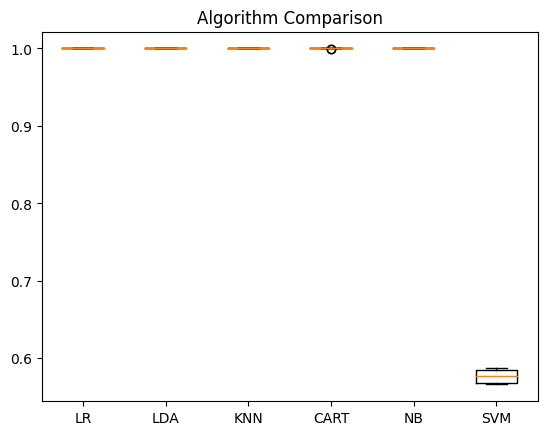

In [594]:
# compare algorithms
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# Load dataset
# Split-out validation dataset
array = matchplay_stats_agg.values
X = array[:,0:len(array[0]) - 1]
y = array[:,len(array[0]) - 1]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=True)
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [602]:
# make predictions
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
# Load dataset

# Split-out validation dataset
array = matchplay_stats_agg.values
X = array[:,0:len(array[0]) - 1]
y = array[:,len(array[0]) - 1]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)
# Make predictions on validation dataset
model = LogisticRegression(solver='liblinear', multi_class='ovr')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

1.0
[[1046    0]
 [   0 1092]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1046
         1.0       1.00      1.00      1.00      1092

    accuracy                           1.00      2138
   macro avg       1.00      1.00      1.00      2138
weighted avg       1.00      1.00      1.00      2138



In [603]:
validation =  pd.DataFrame(X_validation)
validation['winner'] = Y_validation
validation['predicted_winner'] = predictions

In [418]:
upsets = validation[(validation[9] > 0) & (validation['winner'] == 1) | (validation[9] < 0) & (validation['winner'] == 0)]
as_expected = validation[(validation[9] < 0) & (validation['winner'] == 1) | (validation[9] > 0) & (validation['winner'] == 0)]



In [419]:
as_expected

,0,1,2,3,4,5,6,7,8,9,winner,predicted_winner
0,0.0,-2.0,10.0,0.0,6.0,8.0,0.0,0.0,-3.0,-62.0,1.0,1.0
1,-11.0,-3.0,-3.0,3.0,-4.0,-9.0,-1.0,3.0,5.0,37.0,0.0,0.0
2,2.0,-4.0,9.0,12.0,9.0,3.0,0.0,0.0,-3.0,-106.0,1.0,1.0
3,-5.0,-1.0,3.0,9.0,-1.0,-5.0,-1.0,-0.0,1.0,15.0,0.0,0.0
5,-1.0,-2.0,11.0,11.0,14.0,-5.0,0.0,4.0,3.0,-39.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1346,-2.0,-0.0,5.0,-4.0,-7.0,2.0,-1.0,1.0,3.0,343.0,0.0,0.0
1347,-7.0,-1.0,-4.0,-1.0,-8.0,2.0,-0.0,-2.0,-1.0,25.0,0.0,0.0
1349,6.0,3.0,-2.0,2.0,5.0,-1.0,0.0,1.0,-1.0,-26.0,1.0,1.0
1351,-4.0,5.0,11.0,-4.0,-7.0,6.0,-0.0,3.0,6.0,40.0,0.0,0.0


In [421]:
# you need to make this more straghtforward with regard to who won, whether it's an upset, what the sign of the stats mean, etc.

as_expected.loc[:,'predicted_by_model'] = as_expected['winner'] == as_expected['predicted_winner']
upsets.loc[:,'predicted_by_model'] = upsets['winner'] == upsets['predicted_winner']

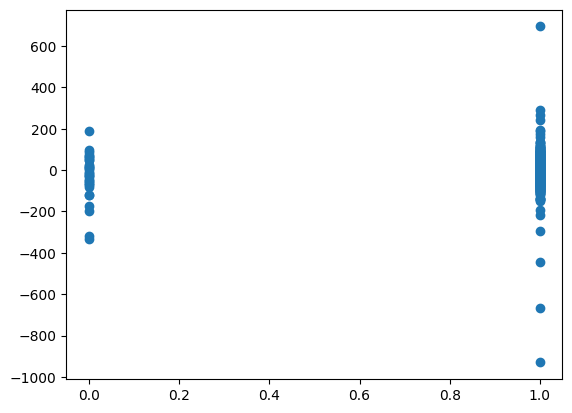

In [422]:
plt.scatter(upsets['predicted_by_model'], upsets[9])


In [426]:

results

[array([0.96125461, 0.95009242, 0.95933457, 0.95378928, 0.94454713,
        0.95378928, 0.95378928, 0.94639556, 0.95378928, 0.95009242]),
 array([0.97232472, 0.95194085, 0.96118299, 0.95563771, 0.94454713,
        0.94824399, 0.95009242, 0.94824399, 0.94824399, 0.95009242]),
 array([0.86162362, 0.90573013, 0.90203327, 0.87615527, 0.84842884,
        0.89279113, 0.8909427 , 0.89279113, 0.89648799, 0.87060998]),
 array([0.90405904, 0.90942699, 0.88724584, 0.89648799, 0.88539741,
        0.9038817 , 0.91312384, 0.90018484, 0.89833641, 0.86876155]),
 array([0.85055351, 0.85767098, 0.85767098, 0.84288355, 0.85397412,
        0.85767098, 0.87245841, 0.85397412, 0.8650647 , 0.86691312]),
 array([0.59225092, 0.6155268 , 0.59704251, 0.61182994, 0.56746765,
        0.60998152, 0.60443623, 0.59149723, 0.60628466, 0.59334566])]